## Lyft Challenge!

https://www.udacity.com/lyft-challenge

In [5]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [27]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from lyft_helpers import *

import pdb
from pathlib import Path

In [8]:
PATH = Path('data/lyft')
list(PATH.iterdir())

[PosixPath('data/lyft/train_masks'),
 PosixPath('data/lyft/train'),
 PosixPath('data/lyft/car_masks'),
 PosixPath('data/lyft/models'),
 PosixPath('data/lyft/tmp')]

In [9]:
def isolate_roads(filename):
    img = Image.open(filename)

    img_np = np.array(img)

    img_np_R = img_np[:,:,0] # Pull out R channel

    img_np_R[img_np_R == 7] = 255
    img_np_R[img_np_R == 6] = 255

    img_np_R[img_np_R != 255] = 0

    new_img = np.stack((img_np_R,img_np_R,img_np_R), axis=-1)
    
    image = Image.fromarray(new_img, 'RGB')
    dest = Path('data/lyft/train_masks')
    image.save(dest/filename.name)

In [10]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

def show_img(im, figsize=(8,8), ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

The following code takes the original labelled images and converts them to a more usable format. Run this code only once.

In [11]:
seg_PATH = Path('train/CameraSeg')
original_segs = list(seg_PATH.iterdir())

# for image in original_segs:
#     isolate_roads(image)

In [12]:
PATH = Path('data/lyft')
input_images = PATH/'train'
output_images = PATH/'train_masks'

list(input_images.iterdir())[:3]

[PosixPath('data/lyft/train/5.png'),
 PosixPath('data/lyft/train/88.png'),
 PosixPath('data/lyft/train/0.png')]

In [13]:
list(output_images.iterdir())[:3]

[PosixPath('data/lyft/train_masks/5.png'),
 PosixPath('data/lyft/train_masks/88.png'),
 PosixPath('data/lyft/train_masks/0.png')]

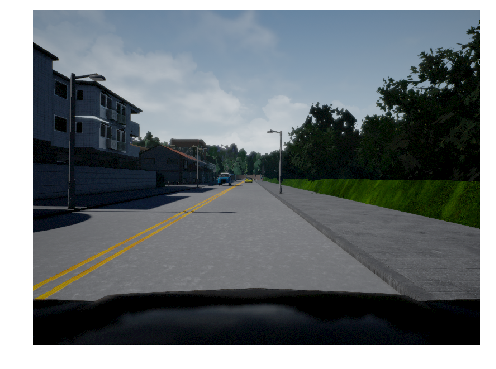

In [14]:
real_world = open_image(list(input_images.iterdir())[0])
show_img(real_world)

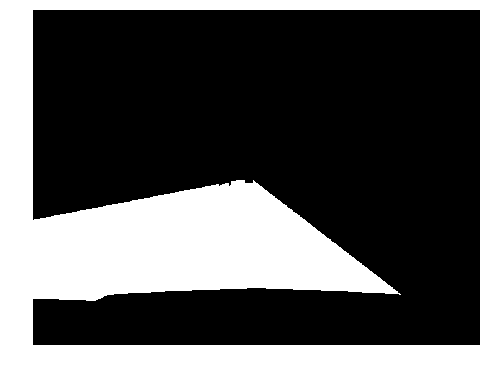

In [15]:
test_seg_image = open_image(list(output_images.iterdir())[0])
show_img(test_seg_image)

## Visualize data

In [16]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'
sz = 128
bs = 64

In [17]:
ims = [open_image(list(input_images.iterdir())[i]) for i in range(16)]
masks = [open_image(list(output_images.iterdir())[i]) for i in range(16)]

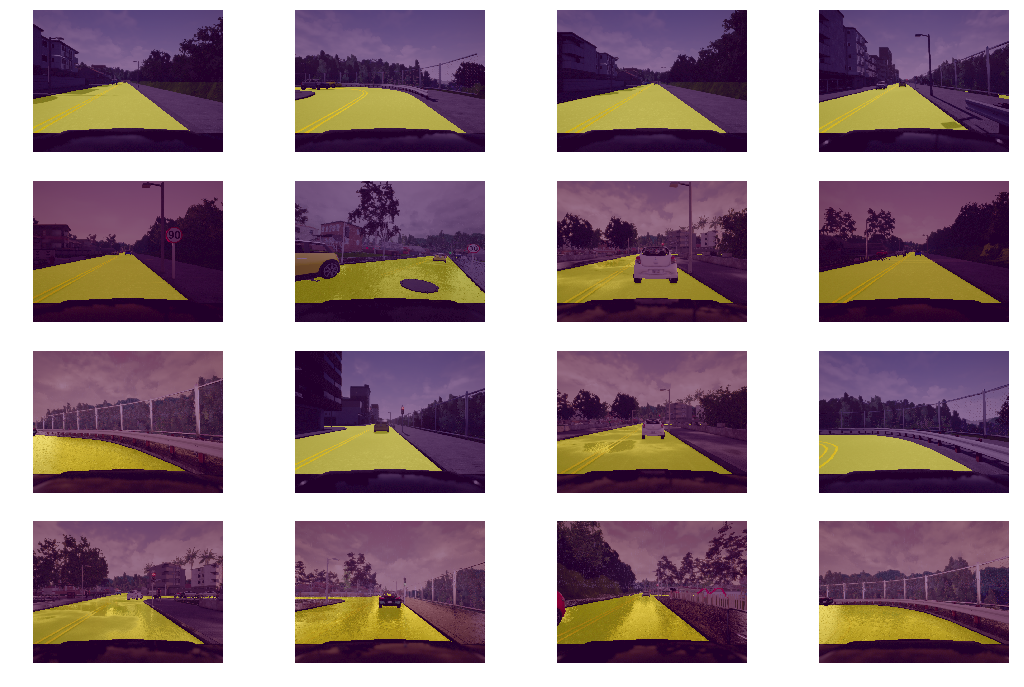

In [18]:
fig, axes = plt.subplots(4,4, figsize=(18,12))
for i, ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(masks[i][...,0], ax=ax, alpha=0.5)

In [19]:
class MatchedFilesDatset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        assert(len(filenames == len(y)))
        self.y = y
        super().__init__(filenames, transform, path)
        
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

In [20]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

len(x_names), len(y_names)

(1000, 1000)

In [21]:
val_idxs = list(range(len(x_names)//5)) # 20% validation split
((val_x, trn_x),(val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names) # split the in/out pairs the same

In [17]:
len(val_x),len(trn_x),trn_x[0], trn_y[0]

(200,
 800,
 PosixPath('data/lyft/train/284.png'),
 PosixPath('data/lyft/train_masks/284.png'))

In [24]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [19]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [20]:
# Use this cell to print the denormed image for visualization purposes
# denorm = md.trn_ds.denorm
# x,y = next(iter(md.aug_dl))
# x = denorm(x)

In [23]:
# This cell is for educational purposes, to see inside the resnet arch

# class Empty(nn.Module): 
#     def forward(self,x): return x

# models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
# learn = ConvLearner(md, models)
# learn.summary()

In [27]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

epoch      trn_loss   val_loss   <lambda>                  
    0      2.119221   3151772.89 0.601741  


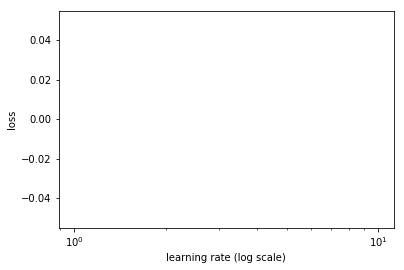

In [30]:
learn.lr_find()
learn.sched.plot()

In [31]:
lr=4e-2

In [32]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.413382   8.905716   0.654545  
    1      0.272132   1.260048   0.781622                  
    2      0.212825   0.2979     0.899307                  
    3      0.178027   0.111697   0.952664                  
    4      0.155771   0.10349    0.953801                  


[array([0.10349]), 0.9538006591796875]

In [34]:
learn.save('tmp')

In [33]:
# torch.save(learn.model, 'road-fullmodel.pt')

In [35]:
learn.load('tmp')

In [36]:
py,ay = learn.predict_with_targs()

In [37]:
ay.shape

(200, 128, 128)

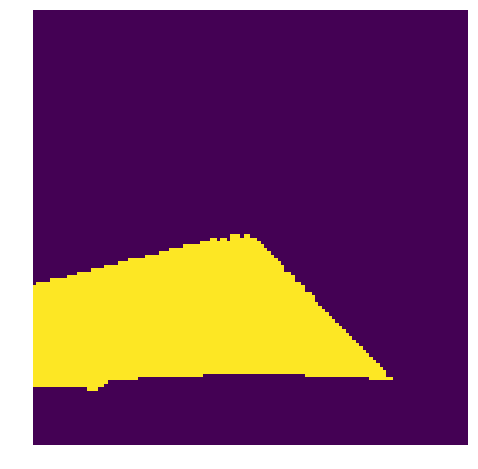

In [38]:
show_img(ay[0]);

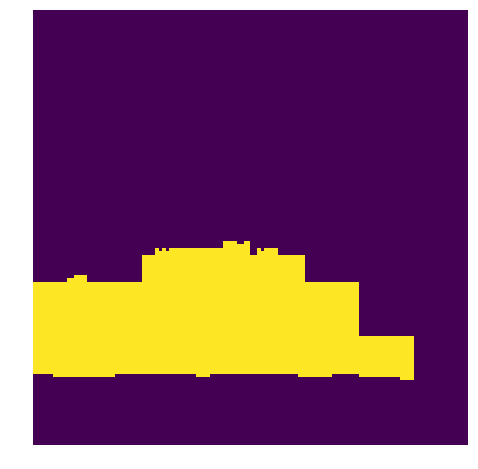

In [39]:
show_img(py[0]>0);

In [40]:
learn.unfreeze()

In [41]:
learn.bn_freeze(True)

In [42]:
lrs = np.array([lr/100, lr/10, lr])/4

In [43]:
learn.fit(lrs, 1, cycle_len=20, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.254972   0.155218   0.929856  
    1      0.20254    0.112033   0.954304                  
    2      0.161542   0.084331   0.962133                  
    3      0.13487    0.07391    0.964839                  
    4      0.116802   0.069551   0.97201                   
    5      0.102723   0.055805   0.976734                  
    6      0.09147    0.051289   0.979171                   
    7      0.082079   0.047167   0.980642                   
    8      0.073981   0.043076   0.983224                   
    9      0.067278   0.040346   0.98406                    
    10     0.061732   0.038242   0.985349                   
    11     0.056741   0.036918   0.986109                   
    12     0.05229    0.035894   0.985458                   
    13     0.048745   0.036041   0.984492                   
    14     0.045896   0.032633   0.987182                   
    15     0.043161   0.032003   0.986793      

[array([0.02854]), 0.9894668579101562]

In [44]:
py,ay = learn.predict_with_targs()

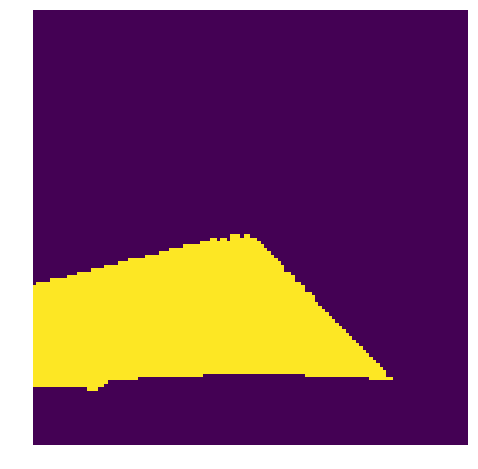

In [45]:
show_img(ay[0]);

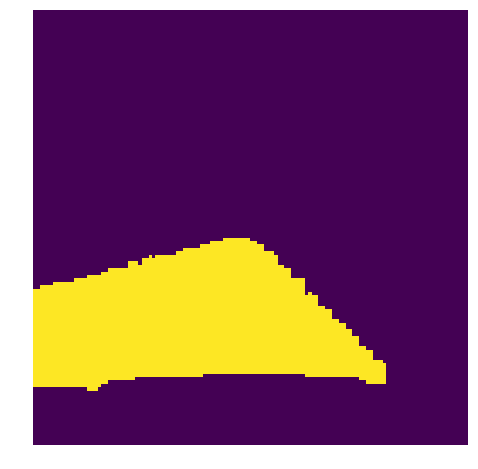

In [46]:
show_img(py[0]>0);

In [47]:
learn.save('road-128')

In [48]:
# torch.save(learn.model, 'road-fullmodel.pt')
# torch.save(learn.model.state_dict(), 'road-weights.pt')

# Time to try a larger image size

In [31]:
sz = 448
bs = 16

In [32]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [33]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [34]:
learn.load('road-128')

 92%|█████████▏| 46/50 [00:52<00:04,  1.14s/it, loss=4.91]

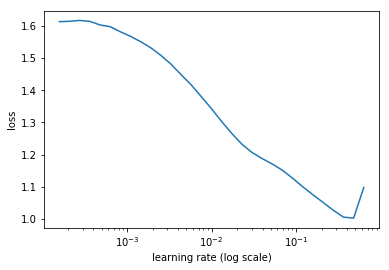

In [35]:
learn.lr_find()
learn.sched.plot()

In [36]:
lr=4e-2
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.338595   0.127957   0.945713  
    1      0.152564   0.084883   0.961579                  
    2      0.090894   0.057348   0.974996                   
    3      0.065692   0.048443   0.980901                   
    4      0.054095   0.046677   0.980431                   


[array([0.04668]), 0.9804314279556274]

In [37]:
learn.save('road-448')

In [38]:
learn.load('road-448')

In [39]:
learn.unfreeze()
learn.bn_freeze(True)

In [40]:
lrs = np.array([lr/100,lr/10,lr])/4

In [41]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.08841    0.036129   0.984551  
    1      0.045783   0.024429   0.989762                   
    2      0.029308   0.018136   0.992337                   
    3      0.02207    0.016779   0.993497                   
    4      0.018342   0.013989   0.994733                   
    5      0.015616   0.012451   0.995178                   
    6      0.013785   0.011223   0.995443                   
    7      0.012605   0.010702   0.995555                   


[array([0.0107]), 0.9955552744865418]

In [42]:
learn.save('road-448-2')

In [43]:
torch.save(learn.model, 'road-fullmodel-3.pt')